# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

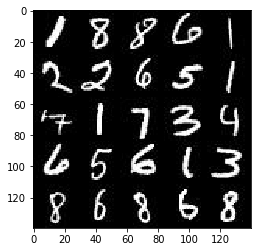

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

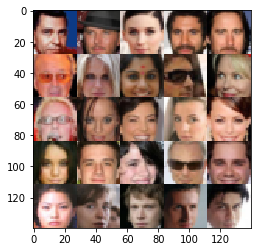

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.06
    dropout = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.layers.dropout(x1, rate=dropout)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.layers.dropout(x2, rate=dropout)
        # 7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.layers.dropout(x3, rate=dropout)
        # 4x4x256
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.layers.dropout(x4, rate=dropout)
        # 4x4x512
        
        flat = tf.reshape(x4, [-1, 4*4*512])        
        logits = tf.layers.dense(flat, 1, activation=None)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.06
    dropout = 0.2

    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)
        x1 = tf.reshape(x1, [-1, 7, 7, 1024])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.layers.dropout(x1, rate=dropout)
        # 7x7x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.layers.dropout(x2, rate=dropout)
        # 14x14x512
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.layers.dropout(x3, rate=dropout)
        # 28x28x256

        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.layers.dropout(x4, rate=dropout)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        output = tf.tanh(logits)
        # 28x28xout_channel_dim

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        #d_opt = tf.train.RMSPropOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        #g_opt = tf.train.RMSPropOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
def plot_losses(d_loss, g_loss):
    fig, ax = pyplot.subplots()
    pyplot.plot(d_loss, label='Discriminator', alpha=0.5)
    pyplot.plot(g_loss, label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = 3 if data_image_mode == 'RGB' else 1
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    

    loss_d, loss_g = [], []
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        last = time.perf_counter()
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model                
                # Sample random noise for G
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                step += 1
                
                if step % 10 == 0:
                    now = time.perf_counter()
                    # execute g twice
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
                    train_loss_d = sess.run(d_loss, feed_dict={input_z: batch_z, input_real: batch_images})
                    loss_d.append(train_loss_d)
                    loss_g.append(train_loss_g)
                    print("Epoch {}/{}... Elapsed {:.2f} seconds,".format(epoch_i+1, epoch_count, now-last),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    last = now
                
                if step % 200 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

        print("Final Output:")
        show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
        plot_losses(loss_d, loss_g)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Elapsed 10.17 seconds, Discriminator Loss: 0.3539... Generator Loss: 7.8445
Epoch 1/2... Elapsed 7.98 seconds, Discriminator Loss: 0.3557... Generator Loss: 7.7550
Epoch 1/2... Elapsed 7.72 seconds, Discriminator Loss: 0.5821... Generator Loss: 5.1470
Epoch 1/2... Elapsed 7.76 seconds, Discriminator Loss: 0.3716... Generator Loss: 6.2770
Epoch 1/2... Elapsed 7.76 seconds, Discriminator Loss: 0.4383... Generator Loss: 3.8463
Epoch 1/2... Elapsed 7.77 seconds, Discriminator Loss: 0.3359... Generator Loss: 7.2158
Epoch 1/2... Elapsed 7.75 seconds, Discriminator Loss: 0.3802... Generator Loss: 6.1503
Epoch 1/2... Elapsed 7.75 seconds, Discriminator Loss: 0.8246... Generator Loss: 7.4279
Epoch 1/2... Elapsed 7.75 seconds, Discriminator Loss: 3.2121... Generator Loss: 0.1990
Epoch 1/2... Elapsed 7.75 seconds, Discriminator Loss: 1.1342... Generator Loss: 0.9245
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 0.5168... Generator Loss: 3.0480
Epoch 1/2... Elapsed 7.80 secon

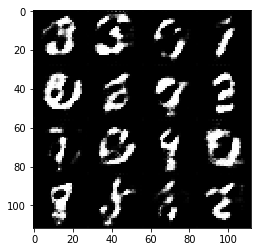

Epoch 1/2... Elapsed 8.21 seconds, Discriminator Loss: 0.8101... Generator Loss: 1.9475
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 1.3179... Generator Loss: 0.5575
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 1.8575... Generator Loss: 0.3849
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 1.4959... Generator Loss: 0.5593
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.5092... Generator Loss: 0.5072
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 0.7687... Generator Loss: 1.3123
Epoch 1/2... Elapsed 7.76 seconds, Discriminator Loss: 1.3682... Generator Loss: 0.6641
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.4566... Generator Loss: 2.0680
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 0.8298... Generator Loss: 1.6997
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 1.1657... Generator Loss: 1.9997
Epoch 1/2... Elapsed 7.82 seconds, Discriminator Loss: 1.4283... Generator Loss: 1.9248
Epoch 1/2... Elapsed 7.78 second

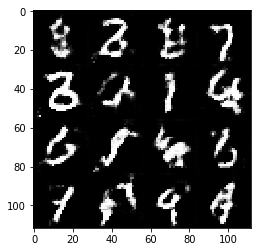

Epoch 1/2... Elapsed 8.13 seconds, Discriminator Loss: 0.9812... Generator Loss: 1.2001
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.0120... Generator Loss: 1.0202
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 0.6351... Generator Loss: 1.7083
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 1.2344... Generator Loss: 0.8106
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 0.9673... Generator Loss: 1.0756
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 1.3791... Generator Loss: 0.6038
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.1369... Generator Loss: 0.8241
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 0.4909... Generator Loss: 2.8666
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 0.5022... Generator Loss: 2.1981
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 0.8475... Generator Loss: 1.7135
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 0.7204... Generator Loss: 1.9182
Epoch 1/2... Elapsed 7.79 second

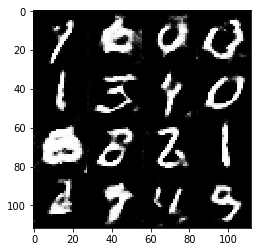

Epoch 1/2... Elapsed 8.14 seconds, Discriminator Loss: 1.0632... Generator Loss: 0.8130
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.2158... Generator Loss: 0.6480
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 1.0941... Generator Loss: 0.7846
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.1717... Generator Loss: 1.7782
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 0.9684... Generator Loss: 1.4659
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 1.9231... Generator Loss: 0.3139
Epoch 1/2... Elapsed 7.83 seconds, Discriminator Loss: 1.4761... Generator Loss: 0.4819
Epoch 1/2... Elapsed 7.78 seconds, Discriminator Loss: 1.1011... Generator Loss: 0.9353
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 1.8310... Generator Loss: 0.3949
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.1859... Generator Loss: 0.7945
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 1.4879... Generator Loss: 0.4502
Epoch 1/2... Elapsed 7.80 second

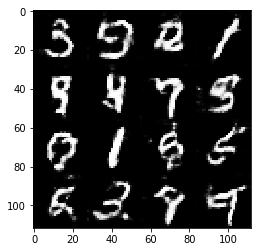

Epoch 1/2... Elapsed 8.15 seconds, Discriminator Loss: 0.8005... Generator Loss: 1.4738
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 0.9849... Generator Loss: 1.8098
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 1.9852... Generator Loss: 0.2905
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.1503... Generator Loss: 1.2490
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.2100... Generator Loss: 1.7486
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 1.0844... Generator Loss: 0.8721
Epoch 1/2... Elapsed 7.80 seconds, Discriminator Loss: 1.7467... Generator Loss: 0.4288
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.6647... Generator Loss: 0.3820
Epoch 1/2... Elapsed 7.81 seconds, Discriminator Loss: 1.2827... Generator Loss: 0.5864
Epoch 1/2... Elapsed 7.79 seconds, Discriminator Loss: 1.9158... Generator Loss: 0.3453
Epoch 1/2... Elapsed 7.82 seconds, Discriminator Loss: 1.7123... Generator Loss: 0.4560
Epoch 1/2... Elapsed 7.78 second

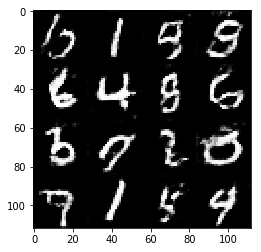

Epoch 2/2... Elapsed 8.13 seconds, Discriminator Loss: 2.6361... Generator Loss: 0.1483
Epoch 2/2... Elapsed 7.82 seconds, Discriminator Loss: 1.2043... Generator Loss: 0.6104
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 0.9850... Generator Loss: 0.9987
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 1.0363... Generator Loss: 1.5520
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 0.9609... Generator Loss: 1.1704
Epoch 2/2... Elapsed 7.82 seconds, Discriminator Loss: 1.1062... Generator Loss: 0.7481
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 1.3063... Generator Loss: 0.5906
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.0132... Generator Loss: 1.4642
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 1.1044... Generator Loss: 2.3970
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 1.1106... Generator Loss: 1.1158
Epoch 2/2... Elapsed 7.78 seconds, Discriminator Loss: 0.8411... Generator Loss: 1.4411
Epoch 2/2... Elapsed 7.82 second

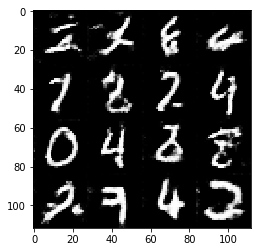

Epoch 2/2... Elapsed 8.15 seconds, Discriminator Loss: 1.3326... Generator Loss: 0.5830
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 1.6948... Generator Loss: 0.3847
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 0.9964... Generator Loss: 0.9223
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 1.3573... Generator Loss: 0.6812
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 2.0574... Generator Loss: 0.2511
Epoch 2/2... Elapsed 7.78 seconds, Discriminator Loss: 1.2721... Generator Loss: 0.9525
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 0.8340... Generator Loss: 1.1822
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 0.9139... Generator Loss: 0.9919
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.3274... Generator Loss: 2.0806
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 1.1935... Generator Loss: 0.6851
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 1.2385... Generator Loss: 0.6551
Epoch 2/2... Elapsed 7.79 second

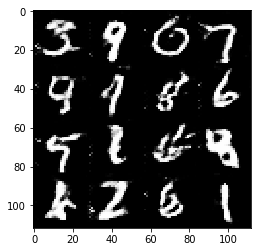

Epoch 2/2... Elapsed 8.15 seconds, Discriminator Loss: 0.9966... Generator Loss: 0.9910
Epoch 2/2... Elapsed 7.82 seconds, Discriminator Loss: 1.6122... Generator Loss: 0.4065
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 1.1494... Generator Loss: 0.7652
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.0178... Generator Loss: 1.0360
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 1.0204... Generator Loss: 0.9955
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 2.9483... Generator Loss: 0.1269
Epoch 2/2... Elapsed 7.78 seconds, Discriminator Loss: 1.3965... Generator Loss: 0.5138
Epoch 2/2... Elapsed 7.83 seconds, Discriminator Loss: 0.9502... Generator Loss: 1.1243
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.1176... Generator Loss: 1.4786
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 1.4422... Generator Loss: 0.5719
Epoch 2/2... Elapsed 7.82 seconds, Discriminator Loss: 1.8093... Generator Loss: 0.3283
Epoch 2/2... Elapsed 7.80 second

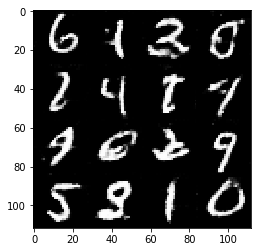

Epoch 2/2... Elapsed 8.25 seconds, Discriminator Loss: 1.0378... Generator Loss: 0.9344
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.2284... Generator Loss: 0.7036
Epoch 2/2... Elapsed 7.82 seconds, Discriminator Loss: 0.6372... Generator Loss: 1.7659
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 0.8623... Generator Loss: 1.1550
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.6295... Generator Loss: 0.4377
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.6485... Generator Loss: 0.4126
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 1.0102... Generator Loss: 0.9170
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.3234... Generator Loss: 0.6270
Epoch 2/2... Elapsed 7.82 seconds, Discriminator Loss: 1.8089... Generator Loss: 0.3833
Epoch 2/2... Elapsed 7.82 seconds, Discriminator Loss: 1.0012... Generator Loss: 0.8959
Epoch 2/2... Elapsed 7.82 seconds, Discriminator Loss: 0.9883... Generator Loss: 0.9408
Epoch 2/2... Elapsed 7.81 second

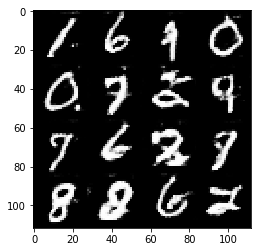

Epoch 2/2... Elapsed 8.14 seconds, Discriminator Loss: 1.5394... Generator Loss: 0.4794
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.7256... Generator Loss: 0.4249
Epoch 2/2... Elapsed 7.80 seconds, Discriminator Loss: 0.7403... Generator Loss: 1.3172
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 0.9461... Generator Loss: 1.7999
Epoch 2/2... Elapsed 7.79 seconds, Discriminator Loss: 1.8937... Generator Loss: 0.3236
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 0.6542... Generator Loss: 2.5952
Epoch 2/2... Elapsed 7.81 seconds, Discriminator Loss: 1.0270... Generator Loss: 0.9101
Final Output:


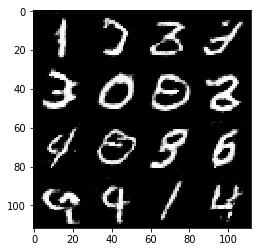

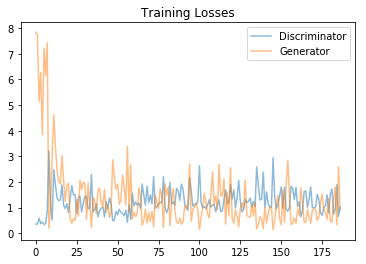

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Elapsed 8.89 seconds, Discriminator Loss: 0.9920... Generator Loss: 2.9210
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.9869... Generator Loss: 15.5643
Epoch 1/1... Elapsed 8.35 seconds, Discriminator Loss: 1.8562... Generator Loss: 0.3965
Epoch 1/1... Elapsed 8.35 seconds, Discriminator Loss: 0.5999... Generator Loss: 1.6322
Epoch 1/1... Elapsed 8.38 seconds, Discriminator Loss: 1.1694... Generator Loss: 3.0355
Epoch 1/1... Elapsed 8.37 seconds, Discriminator Loss: 0.6936... Generator Loss: 1.7234
Epoch 1/1... Elapsed 8.38 seconds, Discriminator Loss: 0.8273... Generator Loss: 1.5945
Epoch 1/1... Elapsed 8.43 seconds, Discriminator Loss: 3.7749... Generator Loss: 0.0694
Epoch 1/1... Elapsed 8.44 seconds, Discriminator Loss: 0.8107... Generator Loss: 1.5600
Epoch 1/1... Elapsed 8.42 seconds, Discriminator Loss: 1.0274... Generator Loss: 1.0002
Epoch 1/1... Elapsed 8.44 seconds, Discriminator Loss: 1.0197... Generator Loss: 1.0577
Epoch 1/1... Elapsed 8.43 secon

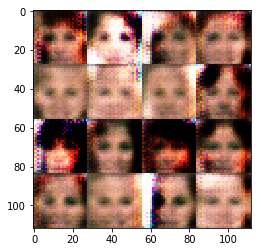

Epoch 1/1... Elapsed 8.85 seconds, Discriminator Loss: 1.0836... Generator Loss: 0.8850
Epoch 1/1... Elapsed 8.49 seconds, Discriminator Loss: 1.7059... Generator Loss: 0.3892
Epoch 1/1... Elapsed 8.51 seconds, Discriminator Loss: 1.1937... Generator Loss: 0.6687
Epoch 1/1... Elapsed 8.47 seconds, Discriminator Loss: 2.3224... Generator Loss: 3.0050
Epoch 1/1... Elapsed 8.48 seconds, Discriminator Loss: 1.3642... Generator Loss: 0.5051
Epoch 1/1... Elapsed 8.50 seconds, Discriminator Loss: 1.1116... Generator Loss: 1.5820
Epoch 1/1... Elapsed 8.50 seconds, Discriminator Loss: 1.2119... Generator Loss: 0.6337
Epoch 1/1... Elapsed 8.51 seconds, Discriminator Loss: 1.4238... Generator Loss: 0.4755
Epoch 1/1... Elapsed 8.48 seconds, Discriminator Loss: 1.0174... Generator Loss: 2.0457
Epoch 1/1... Elapsed 8.51 seconds, Discriminator Loss: 2.0552... Generator Loss: 2.7171
Epoch 1/1... Elapsed 8.54 seconds, Discriminator Loss: 0.8016... Generator Loss: 1.1098
Epoch 1/1... Elapsed 8.51 second

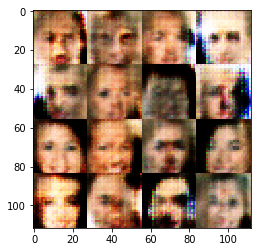

Epoch 1/1... Elapsed 8.96 seconds, Discriminator Loss: 1.9767... Generator Loss: 0.2718
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.6145... Generator Loss: 0.4052
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 0.7559... Generator Loss: 2.2707
Epoch 1/1... Elapsed 8.53 seconds, Discriminator Loss: 1.0885... Generator Loss: 1.2549
Epoch 1/1... Elapsed 8.53 seconds, Discriminator Loss: 1.1120... Generator Loss: 0.7946
Epoch 1/1... Elapsed 8.53 seconds, Discriminator Loss: 1.2528... Generator Loss: 0.8703
Epoch 1/1... Elapsed 8.54 seconds, Discriminator Loss: 1.3445... Generator Loss: 0.7125
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.1989... Generator Loss: 0.7243
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.0636... Generator Loss: 1.3000
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.3142... Generator Loss: 1.0286
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.0797... Generator Loss: 2.7193
Epoch 1/1... Elapsed 8.58 second

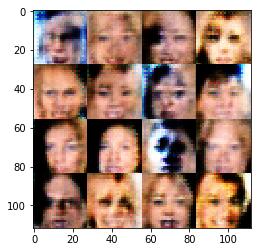

Epoch 1/1... Elapsed 8.90 seconds, Discriminator Loss: 0.9179... Generator Loss: 1.9916
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.2974... Generator Loss: 0.7097
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.4158... Generator Loss: 1.2729
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.0825... Generator Loss: 1.1932
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.3537... Generator Loss: 0.6242
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.7801... Generator Loss: 0.3203
Epoch 1/1... Elapsed 8.54 seconds, Discriminator Loss: 0.9717... Generator Loss: 0.8810
Epoch 1/1... Elapsed 8.54 seconds, Discriminator Loss: 1.0262... Generator Loss: 0.7622
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 3.2393... Generator Loss: 2.9357
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.4556... Generator Loss: 0.6720
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.3654... Generator Loss: 0.7605
Epoch 1/1... Elapsed 8.58 second

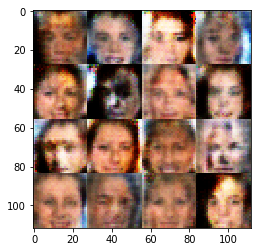

Epoch 1/1... Elapsed 8.93 seconds, Discriminator Loss: 1.3991... Generator Loss: 0.6854
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.3919... Generator Loss: 0.6568
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.3576... Generator Loss: 0.8709
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.2816... Generator Loss: 0.7208
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.9440... Generator Loss: 0.3805
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.7674... Generator Loss: 0.3275
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.9122... Generator Loss: 2.4102
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.8991... Generator Loss: 1.1044
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 0.9501... Generator Loss: 0.8903
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 0.7359... Generator Loss: 1.8095
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.3338... Generator Loss: 0.6411
Epoch 1/1... Elapsed 8.55 second

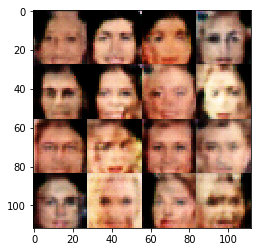

Epoch 1/1... Elapsed 8.93 seconds, Discriminator Loss: 1.9589... Generator Loss: 2.0818
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.9268... Generator Loss: 0.2673
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.7359... Generator Loss: 1.6303
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 0.8576... Generator Loss: 0.9766
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 0.9849... Generator Loss: 1.0735
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.4332... Generator Loss: 0.4297
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 0.8713... Generator Loss: 1.3420
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.1612... Generator Loss: 1.7585
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 2.0200... Generator Loss: 2.6351
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.3422... Generator Loss: 0.5302
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.0419... Generator Loss: 1.1760
Epoch 1/1... Elapsed 8.54 second

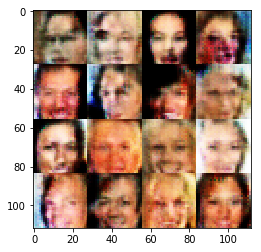

Epoch 1/1... Elapsed 8.94 seconds, Discriminator Loss: 0.9726... Generator Loss: 1.1083
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.3644... Generator Loss: 0.7271
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.2716... Generator Loss: 0.7645
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.1353... Generator Loss: 1.4801
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 0.8746... Generator Loss: 1.1905
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.1341... Generator Loss: 0.6619
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.2371... Generator Loss: 0.6553
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 0.8425... Generator Loss: 1.5403
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 2.5301... Generator Loss: 2.4065
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.1424... Generator Loss: 0.6433
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 0.8247... Generator Loss: 1.0913
Epoch 1/1... Elapsed 8.59 second

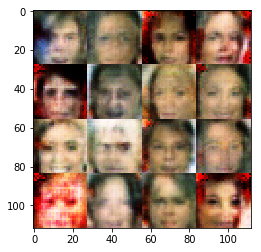

Epoch 1/1... Elapsed 8.97 seconds, Discriminator Loss: 1.2197... Generator Loss: 0.6690
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.1255... Generator Loss: 1.4176
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 0.7935... Generator Loss: 1.5989
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.3755... Generator Loss: 0.6690
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.6611... Generator Loss: 2.0939
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.2963... Generator Loss: 0.8138
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.8979... Generator Loss: 1.1917
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 0.8298... Generator Loss: 1.2579
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 1.3101... Generator Loss: 0.7088
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 0.7265... Generator Loss: 1.9205
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.2495... Generator Loss: 0.6757
Epoch 1/1... Elapsed 8.56 second

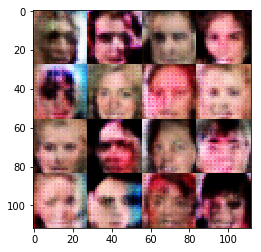

Epoch 1/1... Elapsed 8.94 seconds, Discriminator Loss: 1.2534... Generator Loss: 2.0261
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.0839... Generator Loss: 0.7135
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.3530... Generator Loss: 1.9485
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.5268... Generator Loss: 0.4224
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.0670... Generator Loss: 2.5335
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.1571... Generator Loss: 0.9036
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.4685... Generator Loss: 0.5029
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.0843... Generator Loss: 0.8858
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 0.8790... Generator Loss: 1.4749
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.0626... Generator Loss: 0.9861
Epoch 1/1... Elapsed 8.54 seconds, Discriminator Loss: 1.4325... Generator Loss: 0.7448
Epoch 1/1... Elapsed 8.58 second

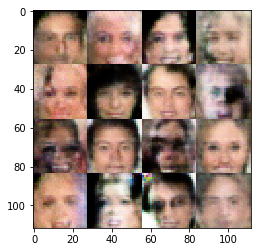

Epoch 1/1... Elapsed 8.95 seconds, Discriminator Loss: 1.3907... Generator Loss: 0.4818
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 3.0370... Generator Loss: 2.9820
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.4056... Generator Loss: 0.7401
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.3465... Generator Loss: 0.6324
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.2754... Generator Loss: 2.1520
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 1.5264... Generator Loss: 0.4088
Epoch 1/1... Elapsed 8.61 seconds, Discriminator Loss: 1.0852... Generator Loss: 1.4978
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.9735... Generator Loss: 0.2568
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.3321... Generator Loss: 0.5020
Epoch 1/1... Elapsed 8.61 seconds, Discriminator Loss: 1.0379... Generator Loss: 0.8614
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.3156... Generator Loss: 1.3447
Epoch 1/1... Elapsed 8.55 second

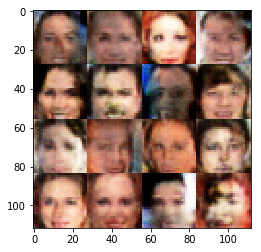

Epoch 1/1... Elapsed 9.08 seconds, Discriminator Loss: 1.3062... Generator Loss: 0.6523
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.1794... Generator Loss: 2.2994
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 0.8105... Generator Loss: 1.2515
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.0952... Generator Loss: 0.6926
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.9624... Generator Loss: 2.2766
Epoch 1/1... Elapsed 8.62 seconds, Discriminator Loss: 1.2853... Generator Loss: 0.6508
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.9655... Generator Loss: 1.3756
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.1831... Generator Loss: 0.6214
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.1503... Generator Loss: 0.9265
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 0.9967... Generator Loss: 1.1439
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.2019... Generator Loss: 0.6738
Epoch 1/1... Elapsed 8.58 second

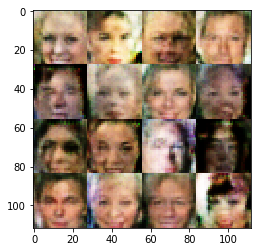

Epoch 1/1... Elapsed 8.94 seconds, Discriminator Loss: 1.1179... Generator Loss: 0.7034
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.6452... Generator Loss: 0.3618
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.0280... Generator Loss: 1.0442
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.6362... Generator Loss: 0.3792
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.3684... Generator Loss: 0.6127
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.7995... Generator Loss: 2.2237
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.9191... Generator Loss: 1.3045
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 1.2767... Generator Loss: 0.7983
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.2145... Generator Loss: 0.7155
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.4576... Generator Loss: 0.4948
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.0182... Generator Loss: 1.0112
Epoch 1/1... Elapsed 8.55 second

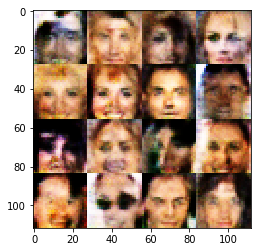

Epoch 1/1... Elapsed 8.99 seconds, Discriminator Loss: 1.7251... Generator Loss: 0.3096
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.9879... Generator Loss: 0.9290
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.3252... Generator Loss: 0.7554
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.2307... Generator Loss: 0.9710
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 0.9767... Generator Loss: 1.0897
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.3270... Generator Loss: 0.6509
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.0228... Generator Loss: 0.8506
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.3016... Generator Loss: 0.7607
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.7440... Generator Loss: 0.3822
Epoch 1/1... Elapsed 8.61 seconds, Discriminator Loss: 1.1319... Generator Loss: 0.8924
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.8974... Generator Loss: 1.4055
Epoch 1/1... Elapsed 8.58 second

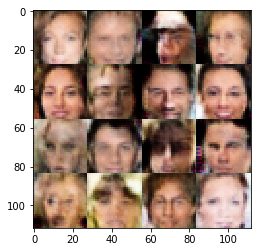

Epoch 1/1... Elapsed 8.96 seconds, Discriminator Loss: 2.9009... Generator Loss: 0.0907
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.3884... Generator Loss: 0.5351
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 0.9281... Generator Loss: 1.1691
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.3928... Generator Loss: 0.5235
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.4263... Generator Loss: 1.1675
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.6748... Generator Loss: 0.3796
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.1684... Generator Loss: 0.8188
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 1.1240... Generator Loss: 1.0017
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 1.4675... Generator Loss: 0.5323
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.3138... Generator Loss: 0.6564
Epoch 1/1... Elapsed 8.61 seconds, Discriminator Loss: 1.3230... Generator Loss: 0.8246
Epoch 1/1... Elapsed 8.59 second

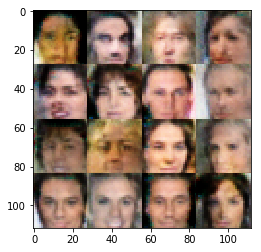

Epoch 1/1... Elapsed 8.97 seconds, Discriminator Loss: 1.5111... Generator Loss: 0.7508
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 2.7983... Generator Loss: 0.1027
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.1649... Generator Loss: 0.9517
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 0.8160... Generator Loss: 1.0970
Epoch 1/1... Elapsed 8.61 seconds, Discriminator Loss: 1.8019... Generator Loss: 1.8633
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.1158... Generator Loss: 0.8135
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.1964... Generator Loss: 0.7536
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.2459... Generator Loss: 0.6304
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 1.1482... Generator Loss: 1.2180
Epoch 1/1... Elapsed 8.60 seconds, Discriminator Loss: 1.3026... Generator Loss: 0.7363
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.7553... Generator Loss: 0.3387
Epoch 1/1... Elapsed 8.58 second

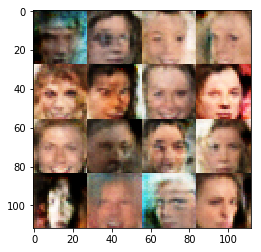

Epoch 1/1... Elapsed 8.96 seconds, Discriminator Loss: 2.0992... Generator Loss: 0.2206
Epoch 1/1... Elapsed 8.56 seconds, Discriminator Loss: 1.6227... Generator Loss: 0.4872
Epoch 1/1... Elapsed 8.63 seconds, Discriminator Loss: 1.3022... Generator Loss: 0.6004
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.2033... Generator Loss: 1.1912
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.1349... Generator Loss: 0.7614
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.1678... Generator Loss: 0.9053
Epoch 1/1... Elapsed 8.59 seconds, Discriminator Loss: 1.4945... Generator Loss: 0.5001
Epoch 1/1... Elapsed 8.55 seconds, Discriminator Loss: 1.6382... Generator Loss: 0.4410
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 1.4767... Generator Loss: 0.8679
Epoch 1/1... Elapsed 8.58 seconds, Discriminator Loss: 1.4616... Generator Loss: 0.7251
Epoch 1/1... Elapsed 8.57 seconds, Discriminator Loss: 0.8306... Generator Loss: 1.4706
Epoch 1/1... Elapsed 8.61 second

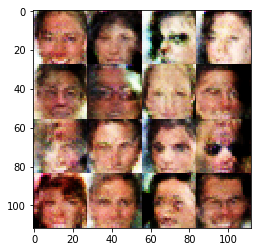

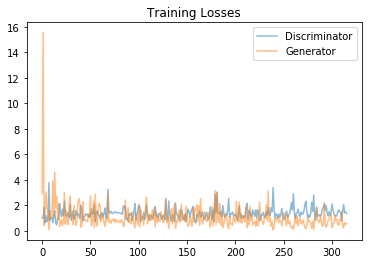

In [14]:
batch_size = 64
z_dim = 256
learning_rate = 0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.